In [1]:
# processing along-track sla from various satellites in the north atlantic
# we consider individual transects and explore variability in sla as a function of length scale 
import numpy as np
import xarray as xr 
from intake import open_catalog
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import netCDF4
import datetime
from scipy.signal import blackman
from scipy.fftpack import fft
from scipy import signal
from scipy import interpolate
from scipy import integrate
from scipy.io import loadmat
from xhistogram.xarray import histogram
from vincenty import vincenty_inverse # distances on an oblate spheroid 
from math import radians, degrees, sin, cos, asin, acos, sqrt

# great circle distance (simpler method than vincenty)
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
# satellite missions 

# - old method with non-catalogged data 
# url_0 = 'gs://pangeo-cnes/alti/j3'  # jason three (2016-2019)
# ds_0 = xr.open_zarr(fsspec.get_mapper(url_0), consolidated=True)

# - new method, catalog of all altimetry missions 
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/altimetry.yaml")
# load Jason 3, Cryosat 2
ds1 = cat['j3'].to_dask()
ds2 = cat['c2'].to_dask()

In [3]:
# define time domain within which to extract/load into memory desired missions 
time_s = '2017-01-01'
time_e = '2017-03-31'
# ds_sub1 = ds1.loc[dict(time=slice(time_s, time_e))]  #j3 doesnt want to slice by time bounds 
ds2_sub = ds2.loc[dict(time=slice(time_s, time_e))]

ds_ll1 = ds1[['latitude', 'longitude', 'sla_filtered', 'sla_unfiltered', 'track']].reset_coords().astype('f4').load()
df1 = ds_ll1.to_dataframe()
ds_ll2 = ds2_sub[['latitude', 'longitude', 'sla_filtered', 'sla_unfiltered', 'track']].reset_coords().astype('f4').load()
df2 = ds_ll2.to_dataframe()

In [4]:
# - subset to shorter time series and within domain I care about 
df1_sub = df1.loc[time_s:time_e]  # slice j3 once in dataframe
lon_w = 280
lon_e = 310
lat_s = 15
lat_n = 45
df_sub_j3 = df1_sub[(df1_sub['longitude'] > lon_w) & (df1_sub['longitude'] < lon_e) & (df1_sub['latitude'] > lat_s) & (df1_sub['latitude'] < lat_n)]
df_sub_c2 = df2[(df2['longitude'] > lon_w) & (df2['longitude'] < lon_e) & (df2['latitude'] > lat_s) & (df2['latitude'] < lat_n)] 

In [5]:
# load sample oleander, linew, coastlines
x1 = loadmat('/home/jovyan/along-track-altimetry-analysis/oleander_adcp_2017.mat')  # oleander adcp
x3 = loadmat('/home/jovyan/along-track-altimetry-analysis/2014may_adcp.mat')  # line w 
x4 = xr.open_dataset('/home/jovyan/along-track-altimetry-analysis/n_atl_coasts.nc')  # line w 

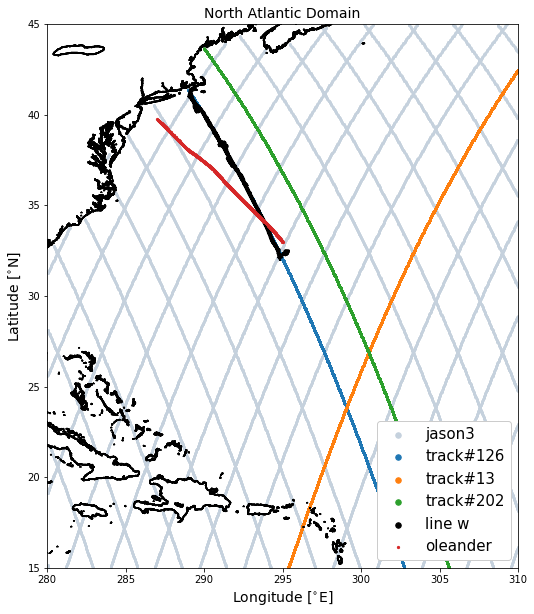

In [6]:
# subsequent analysis is written to process one satellite (select and define below)
this_sat = df_sub_j3
this_sat_key = 'j3'

track_num = np.unique(this_sat['track'])
sat_oleander_track = np.where((track_num == 50) | (track_num == 126) | (track_num == 13) | (track_num == 202))[0]  # 50, 126, 202 (closest to line w)
track_num

# plot (sub domain selected) 
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.contour(x4['longitude'].values + 360, x4['latitude'].values, x4['altitude'].values, colors='k')
ax.scatter(df_sub_j3['longitude'], df_sub_j3['latitude'], s=1, label='jason3', color='#C5D1DD')
ii = 126
ax.scatter(this_sat[this_sat['track'] == ii]['longitude'], 
           this_sat[this_sat['track'] == ii]['latitude'], s=3, label='track#' + str(ii))
ii = 13
ax.scatter(this_sat[this_sat['track'] == ii]['longitude'], 
           this_sat[this_sat['track'] == ii]['latitude'], s=3, label='track#' + str(ii))
ii = 202
ax.scatter(this_sat[this_sat['track'] == ii]['longitude'], 
           this_sat[this_sat['track'] == ii]['latitude'], s=3, label='track#' + str(ii))
           
ax.scatter(x3['txy'][:, 1], x3['txy'][:, 2], s=5, label='line w', color='k')
ax.scatter(x1['oleander_adcp']['lon'][0][0] + 360, x1['oleander_adcp']['lat'][0][0], s=5, label='oleander')
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
w = 1 / np.cos(np.deg2rad(np.nanmean([lat_s, lat_n])))
ax.set_aspect(w)
ax.set_title('North Atlantic Domain', fontsize=14)
ax.set_xlabel(r'Longitude [$^{\circ}$E]', fontsize=14)
ax.set_ylabel(r'Latitude [$^{\circ}$N]', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
lg = plt.legend(handles, labels, fontsize=15, loc=4, framealpha=1)
lg.legendHandles[0]._sizes = [30]
lg.legendHandles[1]._sizes = [30]
lg.legendHandles[2]._sizes = [30]
lg.legendHandles[3]._sizes = [30]
lg.legendHandles[4]._sizes = [30]
plt.show()
# fig.savefig('n_atl_domain_w_tracks.jpg', dpi=300)

In [7]:
print('tracks in domain = ' + str(track_num))

tracks in domain = [ 13.  24.  26.  39.  50.  63.  65.  74.  76.  89. 100. 102. 115. 126.
 139. 141. 150. 152. 165. 167. 176. 178. 191. 202. 217. 226. 228. 241.
 243. 252. 254.]


In [8]:
# - tracks (identify and separate all tracks in selected sub-domain to estimate sla as a function of along-track distance)
dist_by_track = []
track_num_key = []
time_log = []
# loop over each track 
for m in range(4):    
    i = track_num[sat_oleander_track[m]]
    sat_track_i = this_sat[this_sat['track'] == i]
    # distance along track (from arbitrary track starting location)
    # lat_s_d = np.nanmax(this_sat[df_sub1['track'] == i]['latitude'])
    # lon_s_d = np.nanmin(this_sat[df_sub1['track'] == i]['longitude'])
    
    j_s = 0  # initialize starting index of pass 
    this_dist = []  # initialize output 
    this_dist_gc = []
    print('track=' + str(i))
    # loop over each point along track # i to compute and stack distance along track 
    for j in tqdm(range(len(sat_track_i['latitude']))): 
        # if we find that we are starting the track at a different time, recognize as new transect
        # check that we are not at the last index of track i
        
        # define time step between this sample and the next one
        if j < (len(sat_track_i['latitude']) - 1):
            tdiff = sat_track_i.index[j+1] - sat_track_i.index[j]
        else:
            t_diff = 11  #last index 
        
        # if we are at the start of a new pass (i.e. time between current and next sample is greater than 10s)
        if tdiff.days > 1:  # identify next index j as new pass (if tdiff < a few seconds, we're on the same pass)
            print('delta t = ' + str(tdiff))
            this_sla = np.array(sat_track_i['sla_filtered'][(j_s + 1):(j + 1)])[:, None]
            this_sla_unf = np.array(sat_track_i['sla_unfiltered'][(j_s + 1):(j + 1)])[:, None]
            time_log.append(sat_track_i.index[(j_s + 1):(j + 1)].mean())
            # compare great circle and vincenty methods for distance (~6.2km)
            this_dist.append(vincenty_inverse([sat_track_i['latitude'][j - 1], sat_track_i['longitude'][j - 1]], 
                                              [sat_track_i['latitude'][j], sat_track_i['longitude'][j]]).m) 
            this_dist_gc.append(great_circle(sat_track_i['longitude'][j - 1], sat_track_i['latitude'][j - 1],
                                             sat_track_i['longitude'][j], sat_track_i['latitude'][j]))
            
            dist_by_track.append(np.concatenate([np.array(this_dist)[:, None], np.array(this_dist_gc)[:, None],
                                                 this_sla, this_sla_unf], axis=1))
            track_num_key.append(i)
            j_s = j + 1
            this_dist = []
            this_dist_gc = []
        else:
            # distance in meters (using oblate sphoid calculation)
            # (https://nathanrooy.github.io/posts/2016-12-18/vincenty-formula-with-python/)
            if (j - j_s) > 0:  # skip over first index
                this_dist.append(vincenty_inverse([sat_track_i['latitude'][j - 1], sat_track_i['longitude'][j - 1]],
                                                  [sat_track_i['latitude'][j], sat_track_i['longitude'][j]]).m)  
                this_dist_gc.append(great_circle(sat_track_i['longitude'][j - 1], sat_track_i['latitude'][j - 1], 
                                                 sat_track_i['longitude'][j], sat_track_i['latitude'][j]))   
# *note* distances are not cumsummed                

track=13.0


delta t = 9 days 21:48:49.571453
delta t = 9 days 21:48:49.479535
delta t = 9 days 21:48:49.416717
delta t = 9 days 21:48:49.420515
delta t = 9 days 21:48:49.399470
delta t = 9 days 21:48:49.167976
delta t = 9 days 21:48:48.788773
delta t = 9 days 21:48:48.474263

track=50.0


delta t = 9 days 21:49:33.878629
delta t = 9 days 21:49:33.762845
delta t = 9 days 21:49:33.672439
delta t = 9 days 21:49:33.632660
delta t = 9 days 21:49:34.731301
delta t = 9 days 21:49:33.620724
delta t = 9 days 21:49:33.338552
delta t = 9 days 21:49:32.957179
delta t = 9 days 21:49:33.721508

track=126.0


delta t = 9 days 21:49:14.443792
delta t = 9 days 21:49:14.320121
delta t = 9 days 21:49:14.220430
delta t = 9 days 21:49:14.203574
delta t = 9 days 21:49:16.383126
delta t = 9 days 21:49:15.235213
delta t = 9 days 21:49:14.907014
delta t = 9 days 21:49:13.470580

track=202.0


delta t = 9 days 21:48:25.886381
delta t = 9 days 21:48:23.626452
delta t = 9 days 21:48:24.608040
delta t = 9 days 21:48:22.433381
delta t = 9 days 21:48:26.744685
delta t = 9 days 21:48:24.449028
delta t = 9 days 21:48:24.092478
delta t = 9 days 21:48:22.690144



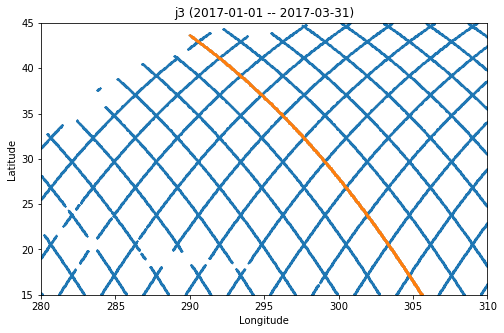

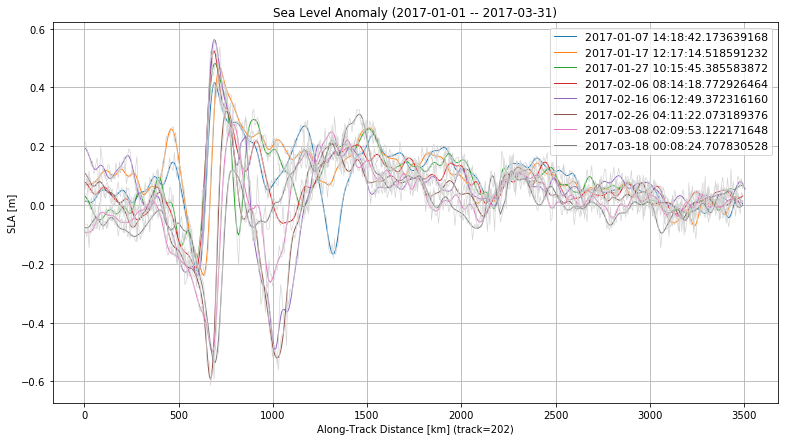

In [9]:
track_i = 202  # desired track number to plot 
this_track = np.where(np.array(track_num_key) == track_i)[0]  # sub indicies from this_dist (tracks looped over)

# plot (sub domain selected, with id'd transect and desired number of transects)
f, ax = plt.subplots(1, 1, figsize = (8, 5))
ax.scatter(this_sat['longitude'], this_sat['latitude'], s=0.5)
ax.scatter(this_sat['longitude'][this_sat['track'] == track_i], this_sat['latitude'][this_sat['track'] == track_i], s=0.75)
ax.set_xlim([lon_w, lon_e])
ax.set_ylim([lat_s, lat_n])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(this_sat_key + ' (' + time_s + ' -- ' + time_e + ')' )
plt.show()

f, ax = plt.subplots(1, 1, figsize = (13, 7))
for i in range(len(this_track)):
    ax.plot(np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0, dist_by_track[this_track[i]][:, 2], linewidth=1, label=time_log[this_track[i]])
    ax.plot(np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0, dist_by_track[this_track[i]][:, 3], linewidth=0.65, color='#D3D3D3')
    # print(np.nanmax(np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0))
ax.set_xlabel('Along-Track Distance [km] (track=' + str(track_i) + ')')
ax.set_ylabel('SLA [m]')
ax.set_title('Sea Level Anomaly (' + time_s + ' -- ' + time_e + ')')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.grid()
plt.show()

In [10]:
# gaussian kernal
# need to define variable width 
# y_values = scipy.stats.norm(mean, standard_deviation)
# scipy.ndimage.gaussian_filter
# https://matthew-brett.github.io/teaching/smoothing_intro.html
# https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

In [11]:
# output desired number of tracks to nc (for matlab spectral analysis)
grid_spacing = 10 # km 
d_grid = np.arange(0, 3000, grid_spacing)  # 10 km grid 3 
for i in range(len(this_track)):
    test_dist1 = np.cumsum(dist_by_track[this_track[i]][:, 0])/1000.0
    test_sla1 = dist_by_track[this_track[i]][:, 2]
    test_sla1_un = dist_by_track[this_track[i]][:, 3]
    # print(len(test_dist1))
    
    if i < 1:
        nc_dist_out = test_dist1 
        nc_sla_out = np.interp(d_grid, test_dist1, test_sla1)[:, None]
        nc_sla_un_out = np.interp(d_grid, test_dist1, test_sla1_un)[:, None] 
    else:
        nc_sla_out = np.concatenate((nc_sla_out, np.interp(d_grid, test_dist1, test_sla1)[:, None]), axis=1)
        nc_sla_un_out = np.concatenate((nc_sla_un_out, np.interp(d_grid, test_dist1, test_sla1_un)[:, None]), axis=1)

In [12]:
# -- export to test w/ matlab (short term step)
# sla_na_out = netCDF4.Dataset('/home/jovyan/along-track-altimetry-analysis/j3_test_grid_out.nc', 'w', format='NETCDF4_CLASSIC')
# # create dimenision
# dist_dim = sla_na_out.createDimension('dist_dim', len(d_grid))
# prof_num_dim = sla_na_out.createDimension('prof_dim', len(this_track))
# # assign variables 
# dist_nc_out = sla_na_out.createVariable('distance', np.float64, ('dist_dim'))
# dist_nc_out[:] = d_grid
# sla_nc_out = sla_na_out.createVariable('sla', np.float64, ('dist_dim', 'prof_dim'))
# sla_nc_out[:] = nc_sla_out
# sla_un_nc_out = sla_na_out.createVariable('sla_un', np.float64, ('dist_dim', 'prof_dim'))
# sla_un_nc_out[:] = nc_sla_un_out
# sla_na_out.close()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


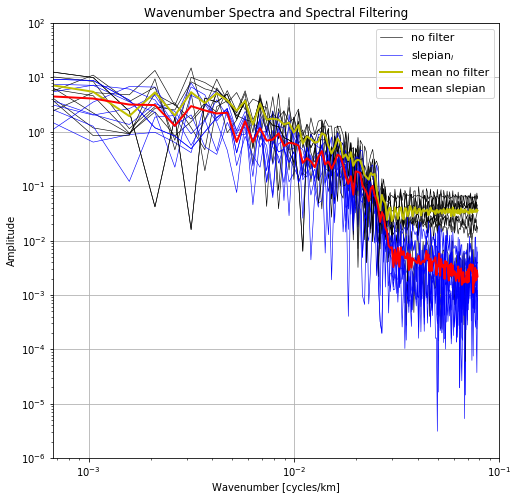

In [13]:
# wavenumber spectra 
# define grid and prep for fft 
# k_grid = np.linspace(0, np.nanmax(np.cumsum(dist_by_track[this_track[0]][1:, 0])/1000.0), len(dist_by_track[this_track[0]][1:, 2]))
k_grid = d_grid
sla_grid = np.nan * np.ones((len(this_track), len(k_grid)))
T = k_grid[1] - k_grid[0]  # sampling interval
N = k_grid.size 
f = np.linspace(0, 1 / T, N)  # 1/T = wavenumber
# above quantities should be set by grid size and not change as we move on 

fft_out = np.nan * np.ones((len(this_track), N))
fft_slep_out = np.nan * np.ones((len(this_track), N))
fft_out_raw = []
f_out = []
N_out = []
for i in range(len(this_track)):  # loop over passes along same track_i made within a time window
    t = np.cumsum(dist_by_track[this_track[i]][1:, 0])/1000.0    # distance (needs to be uniform grid)
    s = dist_by_track[this_track[i]][1:, 2]                      # signal
    T_raw = t[2] - t[1]
    N_raw = t.size
    s_grid = np.interp(k_grid, t, s)
    sla_grid[i, :] = s_grid.copy()
    f_out.append(np.linspace(0, 1 / T_raw, N_raw))
    N_out.append(N_raw)
    
    # - try filtering 
    # - blackman 
    # non-gridded 
    # w_raw = blackman(N_raw)
    ywf_raw = fft(s - np.nanmean(s))
    fft_out_raw.append(ywf_raw)
    # gridded 
    # w_grid = blackman(N)
    ywf_grid = fft((s_grid - np.nanmean(s_grid)), N)  # fft and remove mean 
    fft_out[i, :] = ywf_grid 
    
    # - slepian (intented to remove high frequency variance)
    window = signal.slepian(N, width=0.03)   
    fft_slep_out[i, :] = fft((s_grid - np.nanmean(s_grid))*window, N)

# plot 
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.set_ylabel("Amplitude")
ax.set_xlabel("Wavenumber [cycles/km]")
ax.set_title("Wavenumber Spectra and Spectral Filtering")
for i in range(len(this_track)):
    # ax.plot(f_out[i][:N_out[i] // 2] / (2/np.pi), np.abs(fft_out_raw[i])[:N_out[i] // 2], color='k', linewidth=0.6)  # 1 / N is a normalization factor
    ax.plot(f[:N // 2] / (2/np.pi), np.abs(fft_out[i, :])[:N // 2], color='k', linewidth=0.6)  # 1 / N is a normalization factor
    ax.plot(f[:N // 2] / (2/np.pi), np.abs(fft_slep_out[i, :])[:N // 2], color='b', linewidth=0.6)

# ax.plot(f_out[i][:N_out[i] // 2] / (2/np.pi), np.abs(fft_out_raw[i])[:N_out[i] // 2], color='k', label='no filter', linewidth=0.6)  # 1 / N is a normalization factor    
ax.plot(f[:N // 2] / (2/np.pi), np.abs(fft_out[i, :])[:N // 2], color='k', label='no filter', linewidth=0.6)
ax.plot(f[:N // 2] / (2/np.pi), np.abs(fft_slep_out[i, :])[:N // 2], color='b', label=r'slepian$_i$', linewidth=0.6)    
ax.plot(f[:N // 2] / (2/np.pi), np.nanmean(np.abs(fft_out), axis=0)[:N // 2], color='y', label='mean no filter', linewidth=2)            
ax.plot(f[:N // 2] / (2/np.pi), np.nanmean(np.abs(fft_slep_out), axis=0)[:N // 2], color='r', label='mean slepian', linewidth=2)            
ax.set_ylim([10**(-6), 10**(2)])
ax.set_xlim([1/(0.5 * np.nanmax(k_grid)), 10**(-1)])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.show()

In [14]:
# Sharp Smoothing (from Ian)
def getWeights(n):
    w = np.zeros(n+1) # initialize weights
    for i in range(n):
        integrand = lambda k: 2*(F(k)-1)*(np.cos((i+1)*k)-1)
        w[i] = integrate.quad(integrand,0,np.pi)[0]
    A = 2*np.pi*(np.eye(n) + 2)
    w[1:] = np.linalg.solve(A,w[0:n])
    w[0] = 1 - 2*np.sum(w[1:])
    return w

print('grid spacing = ' + str(grid_spacing))
x = 4; # coarsening factor = desired (coarser resolution) / current grid resolution 
print('coarsening factor = ' + str(x))
print('coarsened grid spacing = ' + str(grid_spacing*x))
F = interpolate.PchipInterpolator(np.array([0,1/x,np.pi/x,np.pi]),np.array([1,1,0,0]))

grid spacing = 10
coarsening factor = 4
coarsened grid spacing = 40


[0.33892592 0.33053704]
[0.2160711  0.20768223 0.18428222]
[0.17301894 0.16463007 0.14123006 0.1076304 ]
[0.15737902 0.14899015 0.12559014 0.09199048 0.05473972]
[0.1536676  0.14527872 0.12187872 0.08827906 0.05102829 0.01670142]
[0.15515766 0.14676878 0.12336878 0.08976912 0.05251835 0.01819148]
[0.15838258 0.1499937  0.1265937  0.09299404 0.05574327 0.0214164 ]
[0.16154067 0.1531518  0.12975179 0.09615213 0.05890137 0.02457449]
[0.16384458 0.1554557  0.1320557  0.09845603 0.06120527 0.0268784 ]
[0.16513869 0.15674981 0.13334981 0.09975015 0.06249938 0.02817251]
[0.16561428 0.15722541 0.1338254  0.10022574 0.06297498 0.02864811]
[0.16559081 0.15720193 0.13380193 0.10020227 0.0629515  0.02862463]
[0.16536678 0.1569779  0.1335779  0.09997823 0.06272747 0.0284006 ]
[0.16514256 0.15675368 0.13335368 0.09975402 0.06250325 0.02817638]


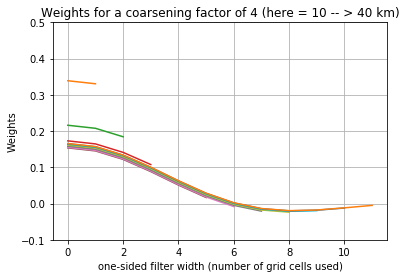

In [15]:
# sample, show weights for various filter widths
print(getWeights(1))
print(getWeights(2))
print(getWeights(3))
print(getWeights(4))
print(getWeights(5))
print(getWeights(6)[0:6])
print(getWeights(7)[0:6])
print(getWeights(8)[0:6])
print(getWeights(9)[0:6])
print(getWeights(10)[0:6])
print(getWeights(11)[0:6])
print(getWeights(12)[0:6])
print(getWeights(13)[0:6])
print(getWeights(14)[0:6])
# **********
# filter width (number of grid points +/- center point) = 2n + 1 (need to obtain n, called the filter radius)
# example filter with of 2n + 1 = 9 or 11 works for coarsening factor of x = 2 (n = 4 or 5)
# for x = 4, n = 10, 2n + 1 = 21
# **********
# -- check/show weights sum to 1 
f, ax = plt.subplots()
for i in range(12):
    ax.plot(getWeights(i))
ax.set_ylim([-0.1, 0.5])    
ax.set_xlabel('one-sided filter width (number of grid cells used)')
ax.set_ylabel('Weights')
ax.set_title('Weights for a coarsening factor of 4 (here = 10 -- > 40 km)')
ax.grid()
plt.show()

In [27]:
# sample filter width selection 
# loop over each pass of the same track and smooth 
# define 5 coarsening regimens, coarsening factor = desired (coarser resolution) / current grid resolution 
x0 = np.array([5, 7.5, 10, 15, 20])  # for a 10km grid, these correspond to 50km, 100km, 200km grid coarsening 
jj = np.nan * np.ones(len(x0))
# this_sla = sla_grid[p, :]
for i in range(len(x0)):
    x = x0[i]
    F = interpolate.PchipInterpolator(np.array([0,1/x,np.pi/x,np.pi]),np.array([1,1,0,0]))
    weight_prev = getWeights(1)
    print('x = ' + str(x))
    for j in range(2, 30):
        this_weight = getWeights(j)
        wd = np.sum(np.abs(this_weight[0:2] - weight_prev[0:2])/np.abs(weight_prev[0:2]))
        # print(wd)
        if wd < 0.04:
            jj[i] = j
            print(str(j) + ' ' + str(getWeights(j)[0:4]))
            print(str(j - 1) + ' ' + str(getWeights(j - 1)[0:4]))
            break
        weight_prev = this_weight    

x = 5.0
7 [0.12326621 0.11894309 0.10656263 0.08778599]
6 [0.12327988 0.11895676 0.1065763  0.08779966]
x = 7.5
9 [0.08241456 0.08112537 0.07733671 0.07127883]
8 [0.08391536 0.08262617 0.07883751 0.07277963]
x = 10.0
12 [0.06191145 0.06136636 0.05974989 0.05711769]
11 [0.06275216 0.06220706 0.0605906  0.0579584 ]
x = 15.0
16 [0.04228287 0.0421211  0.04163828 0.04084183]
15 [0.04307832 0.04291655 0.04243373 0.04163728]
x = 20.0
20 [0.03239987 0.03233158 0.03212732 0.03178884]
19 [0.03300869 0.0329404  0.03273614 0.03239767]


In [28]:
jj

array([ 7.,  9., 12., 16., 20.])

In [29]:
# smooth for each pass and loop over various smoothing options
# -- smooth_sla = np.nan * np.ones((len(x0), len(this_sla)))
smooth_sla = np.nan * np.ones((np.shape(sla_grid)[0], len(x0), len(this_sla)))
for i in range(len(x0)):  # loop over smoothing choice 
    n = np.int(jj[i])
    filter_width = 2*n + 1
    # two sided filter 
    x = x0[i]
    F = interpolate.PchipInterpolator(np.array([0,1/x,np.pi/x,np.pi]),np.array([1,1,0,0]))
    filter0 = np.concatenate((np.flip(getWeights(n))[0:-1], getWeights(n)))
    for p in range(np.shape(sla_grid)[0]):  # loop over each pass 
        this_sla = sla_grid[p, :]
        for j in range(len(this_sla)):  # loop over each grid point and smooth. 
            if j < n:  # edge0
                sla_partial = np.concatenate((np.zeros(n - j), this_sla[0:(j + n + 1)]))
                smooth_sla[p, i, j] = np.nansum( filter0 * sla_partial)
            elif j >= (len(this_sla) - n):  # edge1
                sla_partial = np.concatenate((this_sla[(j - n):], np.zeros(filter_width - len(this_sla[(j - n):]))))
                smooth_sla[p, i, j] = np.nansum( filter0 * sla_partial)    
            else:
                smooth_sla[p, i, j] = np.nansum(filter0 * this_sla[(j - n):(j + n + 1)])

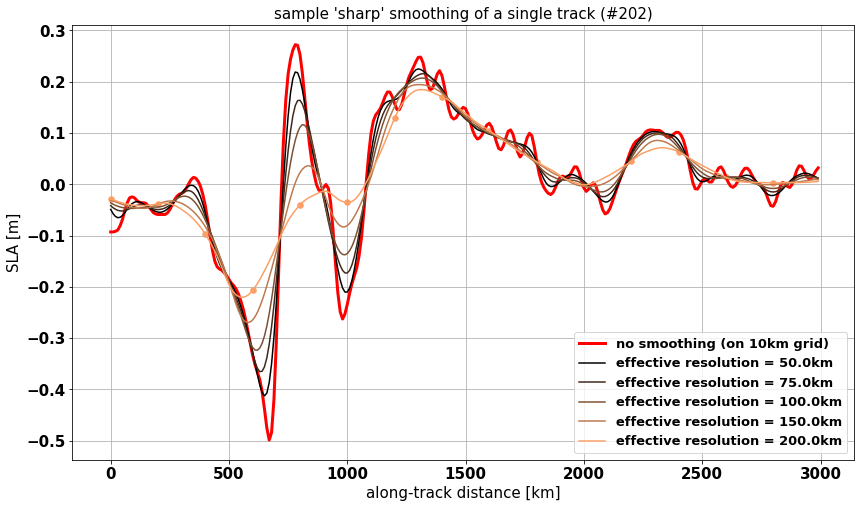

In [36]:
# plot single pass with smoothings 
p = 6
cmap = matplotlib.cm.get_cmap('copper')
fig0, ax = plt.subplots(1, 1, figsize = (14, 8))
ax.plot(d_grid, sla_grid[p, :], color='r', label='no smoothing (on 10km grid)', linestyle='-', linewidth=3)
for i in range(len(x0)):
    ax.plot(d_grid, smooth_sla[p, i, :], linestyle='-', color=cmap(i/len(x0)),
            label='effective resolution = ' + str(grid_spacing*x0[i]) + 'km', linewidth=1.5)
    if i == len(x0) - 1:
        d_grid_coarse = np.arange(0, d_grid[-1], x0[-1]*grid_spacing)
        coarse_sla = np.interp(d_grid_coarse, d_grid, smooth_sla[p, i, :])
        ax.scatter(d_grid_coarse, coarse_sla, s=30, color=cmap(i/len(x0)))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=13)
ax.set_xlabel('along-track distance [km]', fontsize=15)
ax.set_ylabel('SLA [m]', fontsize=15)
ax.set_title("sample 'sharp' smoothing of a single track (#" + str(track_i) + ')', fontsize=15)
font = {'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
ax.grid()
plt.show()
# fig0.savefig('sample_pass_w_smoothing_track' + str(track_i) + '.jpg', dpi=300)

In [19]:
# note distance in km vs. lat/lon filter width 

In [61]:
# recompute spectra to show effect of smoothing
fft_out = np.nan * np.ones((np.shape(sla_grid)[0], len(x0), N))
fft_slep_out = np.nan * np.ones((np.shape(sla_grid)[0], len(x0), N))
f = np.linspace(0, 1 / T, N)  # 1/T = wavenumber
for p in range(np.shape(sla_grid)[0]):  # loop over each pass 
    for i in range(len(x0)):  # loop over each smoothing 
        # gridded 
        ywf_grid = fft((smooth_sla[p, i, :] - np.nanmean(smooth_sla[p, i, :])), N)  # fft and remove mean 
        fft_out[p, i, :] = ywf_grid 
    
        # - slepian (intented to remove high frequency variance) (maybe not needed?)
        window = signal.slepian(N, width=0.03)   
        fft_slep_out[p, i, :] = fft((smooth_sla[p, i, :] - np.nanmean(smooth_sla[p, i, :]))*window, N)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


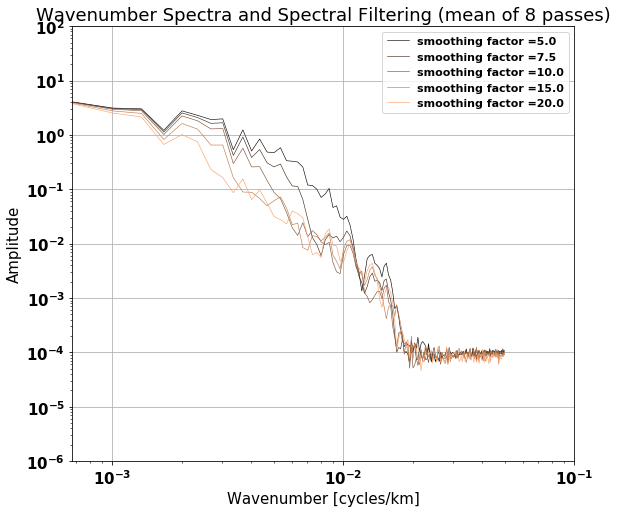

In [63]:
# plot 
fig, ax = plt.subplots(1, 1, figsize = (9, 8))
ax.set_ylabel("Amplitude")
ax.set_xlabel("Wavenumber [cycles/km]")
ax.set_title("Wavenumber Spectra and Spectral Filtering (mean of " + str(np.shape(sla_grid)[0]) + ' passes)')
for i in range(len(x0)):
    ax.plot(f[:N // 2], np.nanmean(np.abs(fft_slep_out[:, i, :N // 2]), axis=0), 
            color=cmap(i/len(x0)), linewidth=0.6, label='smoothing factor =' + str(x0[i])) 
    # ax.plot(f[:N // 2] / (2/np.pi), np.abs(fft_slep_out[i, :])[:N // 2], color='b', linewidth=0.6)
       
ax.set_ylim([10**(-6), 10**(2)])
ax.set_xlim([1/(0.5 * np.nanmax(k_grid)), 10**(-1)])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=11)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
plt.show()
fig.savefig('spectra_test_track202.jpg', dpi=300)

In [52]:
1/(2*10**(-2))

50.0

In [21]:
# -- satellite temporal coverage 
# -- only run once to determine time bounds of each satellite mission in the archive
# list_cat = list(cat)
# t_sat_st = []
# t_sat_en = []
# for i in tqdm(range(len(list_cat))):
#     ds_i = cat[list_cat[i]].to_dask()
#     t_sat_st.append(ds_i.time.data[0])
#     t_sat_en.append(ds_i.time.data[-1])

# time_order = np.argsort(t_sat_st)
# count = 0 
# f, ax = plt.subplots(1, 1, figsize = (14, 7))
# for i in time_order:
#     this_mish = datetime.datetime.utcfromtimestamp(t_sat_st[i].tolist()/1e9)
#     this_mish_e = datetime.datetime.utcfromtimestamp(t_sat_en[i].tolist()/1e9)
#     this_delta = this_mish_e - this_mish
#     tm_y = this_mish.year + this_mish.month/12
#     ax.broken_barh([(tm_y, this_delta.days/365)], (-10 + count*10, 4), facecolors =('tab:green')) 
#     count = count + 1
# ax.set_yticks(np.arange(-8, 200, 10))
# ax.set_xticks([1990, 1995, 2000, 2005, 2010, 2015, 2020])
# sat_key = np.array(list_cat)
# ax.set_yticklabels(sat_key[time_order])
# ax.set_title('Satellite Mission Coverage', fontsize=14)
# ax.set_xlabel('Date', fontsize=14)
# ax.set_ylabel('Satellite Name', fontsize=14)
# ax.grid()
# plt.show()
# # f.savefig('sat_temporal_coverage.pdf')

In [22]:
# for later 
# # bin measurements by lat lon and look and variance of measurements in each box 
# lon_bins = np.arange(280, 330, 2)
# lat_bins = np.arange(15, 50, 2)

# # helps with memory management
# ds_ll_chunked = ds_ll.chunk({'time': '5MB'})

# sla_variance = histogram(ds_ll_chunked.longitude, ds_ll_chunked.latitude,
#                          bins=[lon_bins, lat_bins],
#                          weights=ds_ll_chunked.sla_filtered.fillna(0.)**2)

# norm = histogram(ds_ll_chunked.longitude, ds_ll_chunked.latitude, bins=[lon_bins, lat_bins])

# # let's get at least 200 points in a box for it to be unmasked
# thresh = 200
# sla_variance = sla_variance / norm.where(norm > thresh)
# # sla_variance.plot(x='longitude_bin', figsize=(12, 6), vmax=0.2)